# Clustering

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy import stats

# Clustering
from sklearn import cluster, preprocessing, metrics, mixture
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Visualization
from sklearn import manifold

Defining a few functions which will help us with clustering

In [2]:
# getting most frequent product label for each customer
def get_first_element(s):
    """In the case s is a pd.Series containing tuples of arrays, returns the first element of the first
    array."""
    
    return s.map(lambda x: x[0][0])

# RFM

In [3]:
rfm = pd.read_csv("./data/rfm.csv")

# RFM and Products

Loading the datasets we will use in this section

In [96]:
products_items = pd.read_csv("./data/products_items.csv")

We merge the rfm data for each customer and the new product categories in order to perform a clustering of customers based on their rfm characteristics and the type of product they typically buy.

In [103]:
rfm_product = pd.read_csv("./data/rfm_product.csv")
rfm_product.head()

,customer_unique_id,order_id,purchase_recency,frequency,total_order_value,product_id,product_category_name_english,product_weight_g,price,product_volume,freight_to_total_price,product_label
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,160,1,142.0,372645c7439f9661fbbacfd129aa92ec,bed_bath_table,1500.0,129.90,7616.0,0.084567,1
13,0006fdc98a402fceb4eb0ee528f6a8d4,6681163e3dab91c549952b2845b20281,456,1,29.0,7ca5f56188492e30c50ba64de188aae7,bed_bath_table,200.0,13.90,4800.0,0.520690,1
15,00090324bbad0e9342388303bb71ba0a,85bf8863657bff31006811d45d1c8db9,207,1,64.0,f6fa93875f4a7dac03e0a22143f4d815,bed_bath_table,450.0,49.95,4275.0,0.215363,1
19,000c8bdb58a29e7115cfc257230fb21b,34801c59d6ec5c5e89bfefb6ebef314d,308,1,29.0,f07dfd51b27ae763526ca43745920b7d,bed_bath_table,175.0,13.90,1794.0,0.520690,1
21,000de6019bb59f34c099a907c151d855,c6d61340bd8baeedca7cc8e7f7ec07e9,425,1,257.0,9e572ff4654f7064419d97a891a8b0fc,bed_bath_table,1900.0,139.90,11515.0,0.110221,1


Let us now move on to clustering the customers based on RFM, and product_label

In [104]:
cluster_products_customers = rfm_product[["customer_unique_id",
                                          "purchase_recency", 
                                          "frequency", 
                                          "total_order_value",
                                          "product_label"]].copy()

# getting the most frequent product type (product label) for each customer, in order to characterize each
# customer according to the most frequently bought product type.

# first, we get rid of potential duplicates
cluster_products_customers.drop_duplicates(inplace=True)

# Then, most frequent product type for each customer
product_labels = (cluster_products_customers
                    .groupby("customer_unique_id")["product_label"]
                    .agg(stats.mode)
                    .apply(lambda x: x[0][0])
                    .reset_index()
          )

# 
cluster_products_customers = (pd.merge(cluster_products_customers.drop(columns="product_label"),
                                       product_labels,
                                       on="customer_unique_id"
                                      )
                             )

# Again, cleaning up from potential duplicates arising from the merge operation
cluster_products_customers.drop_duplicates(inplace=True)

# Finally, we one-hot encode the product_label column
clust_df = pd.concat((cluster_products_customers.drop(columns=["customer_unique_id","product_label"]), 
                      pd.get_dummies(cluster_products_customers.product_label, prefix="label")), axis=1)

Finding out the optimal number of clusters
1. silhouette score

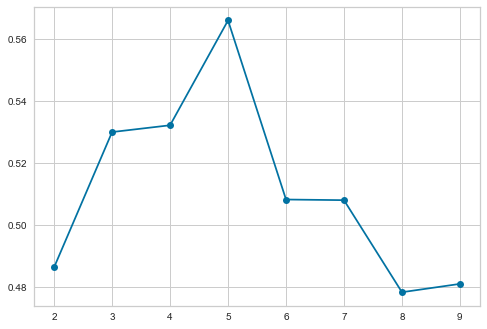

In [105]:
scaler = preprocessing.StandardScaler().fit(clust_df)
clust_df_std = pd.DataFrame(data=scaler.transform(clust_df), columns=clust_df.columns)

silhouettes = []

for num_clusters in range(2, 10):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(clust_df_std)
    silh = metrics.silhouette_score(clust_df_std, cls.labels_, sample_size=1000)
    silhouettes.append(silh)

plt.plot(range(2, 10), silhouettes, marker='o')

2. Elbow method

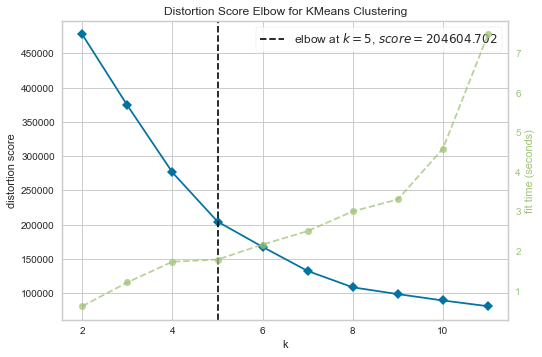

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [106]:
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(clust_df_std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Trying another clustering algorithm - the idea is to compare the silhouette scores with the previous method

Assessing the shape of the clusters

In [ ]:
for n_clust in range(3, 6):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(clust_df_std.sample(10000))    # Fit the data to the visualizer
    visualizer.poof()

Assessing the stability of clusters

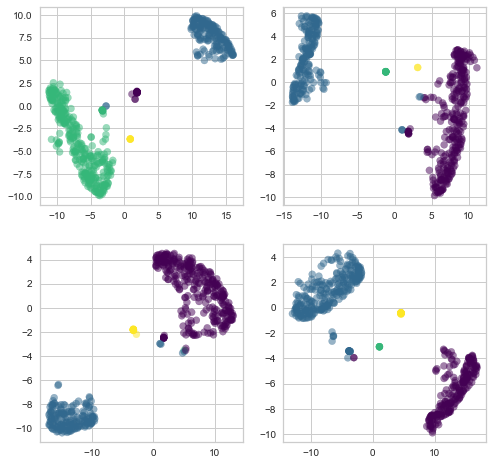

In [152]:
clust_std = clust_df_std.copy()
clust = clust_df.copy()

fig = plt.figure(figsize=(8, 8))

for i in range(4):
    
    clusters = cluster.KMeans(n_clusters=4).fit(clust_std)
    
    # adding the labels obtained from clustering
    #clust["customer_label"] = clusters.labels_
    clust_std["customer_label"] = clusters.labels_
    
    # The coordinates (standardized) for each customer, and the associated category
    #categories_norm = pd.concat((clust_std, 
    #                         clust["product_category_name_english"]
    #                        ),
    #                        axis=1
    #                       )

    # Visualization
    XX = clust_std.sample(500).copy()
    X = XX.drop(columns="customer_label")
    tsne = manifold.TSNE(n_components=2, perplexity=100, n_iter=2000)
    X_tsne = tsne.fit_transform(X)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=XX["customer_label"], cmap="viridis", alpha=0.5)
plt.show()

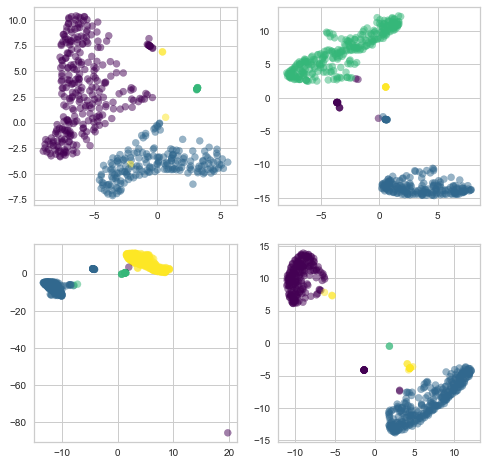

In [153]:
clust_std = clust_df_std.copy()
clust = clust_df.copy()

fig = plt.figure(figsize=(8, 8))

for i in range(4):
    
    clusters = mixture.GaussianMixture(n_components=4).fit(clust_std)
    
    # adding the labels obtained from clustering
    #clust["customer_label"] = clusters.labels_
    clust_std["customer_label"] = clusters.predict(clust_std)
    
    
    # Visualization
    XX = clust_std.sample(500).copy()
    X = XX.drop(columns="customer_label")
    tsne = manifold.TSNE(n_components=2, perplexity=100, n_iter=2000)
    X_tsne = tsne.fit_transform(X)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=XX["customer_label"], cmap="viridis", alpha=0.5)
plt.show()

In [119]:
clusters = cluster.KMeans(n_clusters=6, n_init=10).fit(clust_df_std)
centroids = clusters.cluster_centers_

centroids = pd.DataFrame(scaler.inverse_transform(centroids).round(2), columns=clust_df.columns)
centroids

,purchase_recency,frequency,total_order_value,label_0,label_1,label_2,label_3
0,434.17,1.00,152.47,-0.0,1.00,0.0,0.00
1,174.54,1.00,162.53,-0.0,1.00,0.0,0.00
2,264.75,1.03,873.28,1.0,0.00,0.0,0.00
3,279.90,1.00,151.76,-0.0,0.00,0.0,1.00
4,268.47,2.12,311.15,0.0,0.75,0.0,0.25
5,308.55,1.02,225.79,0.0,-0.00,1.0,-0.00


434 d. = approx 1 year 3 months\
174 d. = approx 6 months\
265 d., 268 d., 280 d. = approx 9 months\
308 d. = approx 10 months

New purchase <--> new customer: 
* low monetary value purchases (type 1) = main clients. They arrive regularly, from the beginning? It seems like they have been purchasing for a slightly higher value lately.

* Some buy more than once: but other than that, they bear the same characteristics as the legacy customers. (approx 150BRL/purchase, from cat. 1 and 3. 

* Cat. 3 seems to be linked with purchases made about 270-280 days ago (9 months). Did olist added new specific items to its catalogue at that time?

* Cat 0 definitely associated to high monetary value customers. They bought only once over the past 2 and a half years, about 9 months ago (a little less).

### results for the clustering of customers based on their rfm and the main categories of products purchased

**Personae:**

|Persona#|N samples|purchase_recency|frequency|total_order_value|category 1|category 2|category 3|category 4|
|---|---|---|---|---|---|---|---|---|
|0|3467|305|1.03|249|0|1|0|0|
|1|43758|291|1|159|0|0|1|0|
|2|43490|281|1|151|1|0|0|0|
|3|250|266|1|1169|0.004|0|0|0.996|
|4|2878|268|2.1|311|0.61|0.003|0.39|0|

# RFM and Geolocation

## Geolocation clustering

**Clustering by zip code, and geolocalisation**

In [157]:
prefix_clustering = pd.read_csv("./data/prefix_clustering.csv")
prefix_clustering.head()

,customer_zip_code_prefix,geolocation_lat,geolocation_lng,tov_avg,size
0,1003,-23.548994,-46.635731,98.9700,1.0
1,1004,-23.549799,-46.634757,99.0550,2.0
2,1005,-23.549456,-46.636733,95.1200,6.0
3,1006,-23.550102,-46.636137,434.0250,2.0
4,1007,-23.550046,-46.637251,126.3875,4.0


First attempt with DBSCAN to take advantage of the higher density of population along the coast and in some inner regions

Counter({0: 7566, -1: 3859, 2: 866, 1: 756, 4: 667, 5: 605, 3: 485})


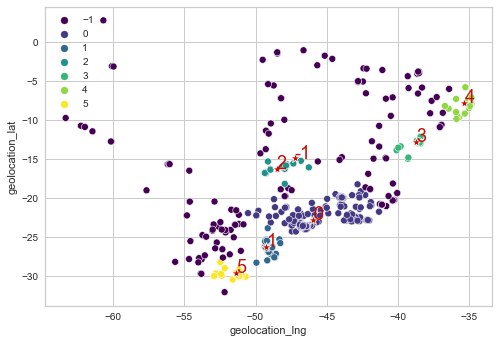

In [281]:
X = prefix_clustering[["geolocation_lat", "geolocation_lng"]].copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

dbscan = cluster.DBSCAN(eps=0.2, min_samples=300).fit(X_std)
print(Counter(dbscan.labels_))


# adding the labels obtained from clustering
X["label"] = dbscan.labels_

centroids = pd.DataFrame(data=X.groupby("label").mean(), 
                         columns= X.columns
                        ) 

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=X, x="geolocation_lng", y="geolocation_lat", hue="label", palette="viridis", ax=ax)
sns.scatterplot(data=centroids, x="geolocation_lng", y="geolocation_lat", marker="*", s=100, color="r", ax=ax)

for i in range(centroids.shape[0]):
    ax.text(centroids.to_numpy()[i, 1], centroids.to_numpy()[i, 0], str(i-1), fontsize=18, color="r")

plt.show()

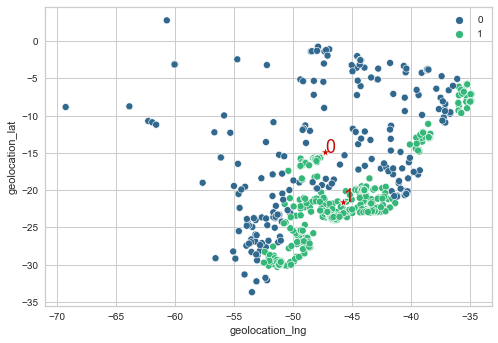

In [282]:
# adding the labels obtained from clustering
prefix_clustering["urban_coastal"] = dbscan.labels_
prefix_clustering.urban_coastal = prefix_clustering.urban_coastal.apply(lambda x: 0 if x==-1 else 1)

centroids = pd.DataFrame(data=prefix_clustering[["geolocation_lat", "geolocation_lng", "urban_coastal"]]
                         .groupby("urban_coastal").mean(), 
                         columns= ["geolocation_lat", "geolocation_lng", "urban_coastal"]
                        ) 

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=prefix_clustering.sample(1000), 
                x="geolocation_lng", 
                y="geolocation_lat",
                hue="urban_coastal", 
                palette="viridis",
                ax=ax)
sns.scatterplot(data=centroids,
                x="geolocation_lng",
                y="geolocation_lat",
                marker="*", 
                s=100,
                color="r",
                ax=ax)

for i in range(centroids.shape[0]):
    ax.text(centroids.to_numpy()[i, 1], centroids.to_numpy()[i, 0], str(i), fontsize=18, color="r")

plt.show()

Let us check that a city like Sao Paulo isn't made of mostly "noisy", i.e. non dense zip codes 

In [270]:
pref_clust = prefix_clustering.copy()
sao_paulo_zip = pd.read_csv("./data/sao_paulo_zip.csv")

sao_paulo_zip.head()

,Sao_Paulo_zip
0,1151
1,4534
2,5704
3,5416
4,5713


In [271]:
pref_clust.loc[pref_clust.customer_zip_code_prefix.isin(sao_paulo_zip.Sao_Paulo_zip), "label"].value_counts()

1    2835
Name: label, dtype: int64

Where are located the various zip codes, depending on their label?

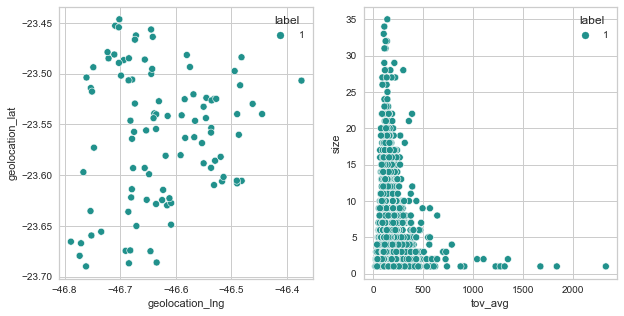

In [272]:
sao_paulo = pref_clust.loc[pref_clust.customer_zip_code_prefix.isin(sao_paulo_zip.Sao_Paulo_zip)]
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(data=sao_paulo.sample(100), x="geolocation_lng", y="geolocation_lat", hue="label", 
                palette="viridis", ax=ax1)
sns.scatterplot(data=sao_paulo, x="tov_avg", y="size", hue="label", palette="viridis", ax=ax2)
plt.show()

**clustering by tov_avg and size**

Finding out the optimal number of clusters
1. Silhouette score

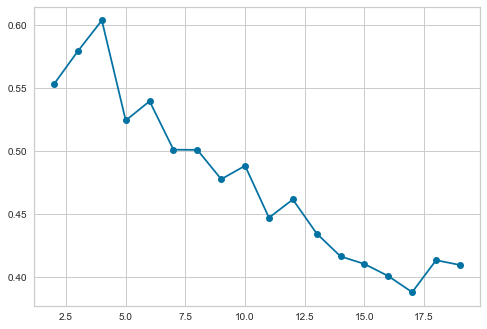

In [301]:
X = prefix_clustering[["tov_avg", "size", "urban_coastal"]].copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

silhouettes = []

for num_clusters in range(2, 20):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(X_std)
    silh = metrics.silhouette_score(X_std, cls.labels_)
    silhouettes.append(silh)

plt.plot(range(2, 20), silhouettes, marker='o')

2. Elbow method

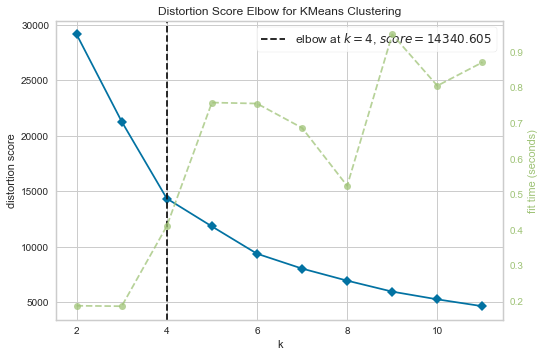

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [302]:
# Instantiate the clustering model and visualizer
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_std)    # Fit the data to the visualizer
visualizer.poof() 

Assessing the shape of clusters

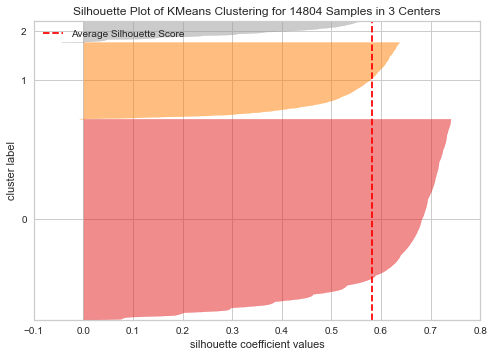

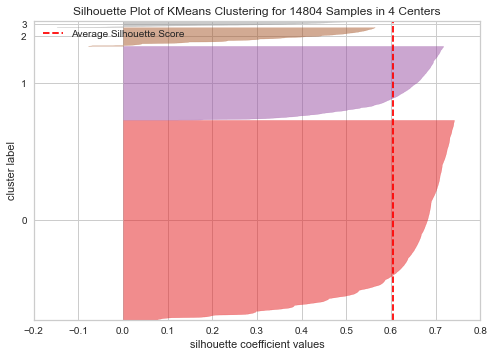

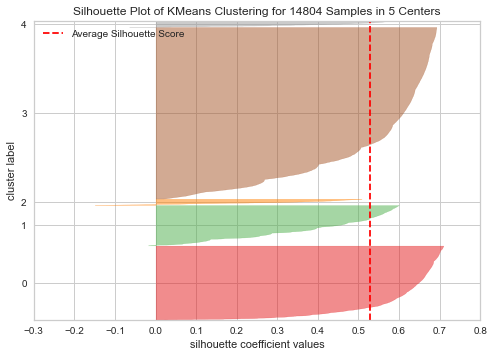

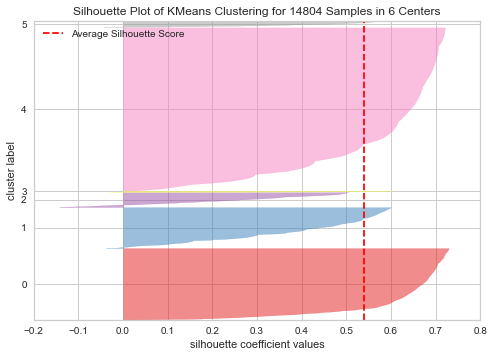

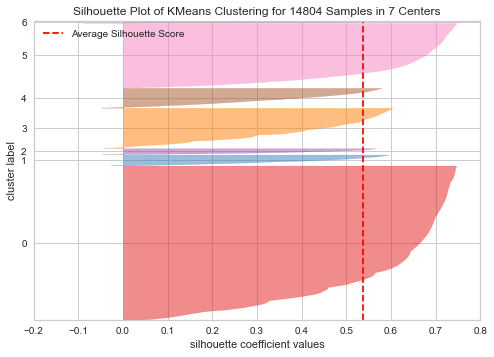

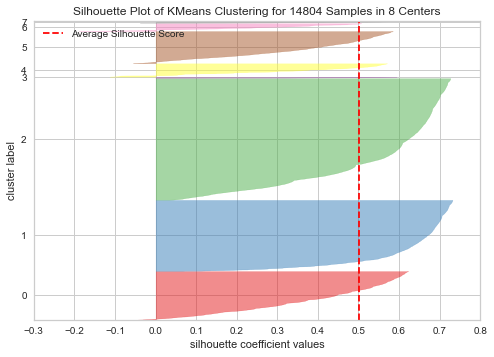

In [303]:
for n_clust in range(3, 9):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(X_std)    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

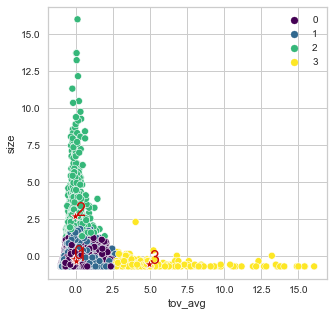

In [321]:
X = prefix_clustering[["tov_avg", "size", "urban_coastal"]].copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

# adding the labels obtained from clustering
clusters = cluster.KMeans(n_clusters=4).fit(X_std)
labels = clusters.labels_
X_std["label"] = clusters.labels_

centroids = pd.DataFrame(data=clusters.cluster_centers_, 
                         columns= X.columns
                        ) 

fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=X_std, x="tov_avg", y="size", hue="label", palette="viridis", ax=ax)
sns.scatterplot(data=centroids, x="tov_avg", y="size", marker="*", s=100, color="r", ax=ax)

for i in range(centroids.shape[0]):
    ax.text(centroids.to_numpy()[i, 0], centroids.to_numpy()[i, 1], str(i), fontsize=18, color="r")

In [322]:
real_centroids = pd.DataFrame(scaler.inverse_transform(centroids), columns=centroids.columns)
real_centroids["count"] = sorted(Counter(clusters.labels_).items())
real_centroids["count"] = real_centroids["count"].apply(lambda x: x[1])
real_centroids

,tov_avg,size,urban_coastal,count
0,142.668355,5.249363,1.000000e+00,9809
1,166.152265,4.165255,1.176836e-14,3661
2,157.341348,29.617391,9.207729e-01,1035
3,854.297604,2.354515,6.120401e-01,299


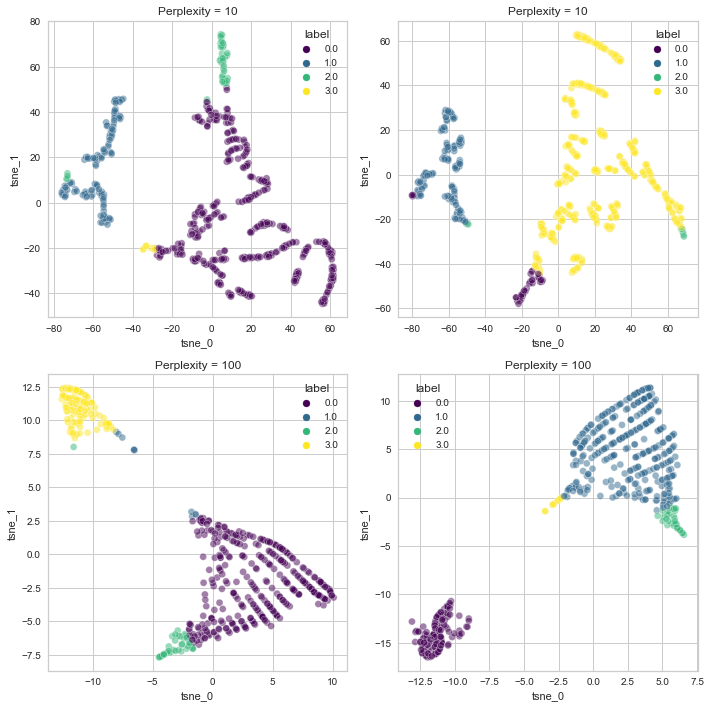

In [324]:
X = prefix_clustering[["tov_avg", "size", "urban_coastal"]].copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

fig = plt.figure(figsize=(10, 10))

for i, perp in zip(range(4), [10, 10, 100, 100]):
    X_std = X_std.sample(frac=1).reset_index(drop=True)
    clusters = cluster.KMeans(n_clusters=4).fit(X_std)
    
    # adding the labels obtained from clustering
    X_std["label"] = clusters.labels_
    
    # Visualization
    XX = X_std.sample(500).copy()
    X = XX.drop(columns="label")
    tsne = manifold.TSNE(n_components=2, perplexity=perp, n_iter=3000)
    X_tsne = tsne.fit_transform(X)
    
    X_tsne = pd.DataFrame(data=np.concatenate((X_tsne, np.array(XX.label, ndmin=2).T), axis=1),
                          columns=["tsne_0", "tsne_1", "label"])
    
    
    ax = fig.add_subplot(2, 2, i+1)
    sns.scatterplot(data=X_tsne, x="tsne_0", y="tsne_1", hue="label", palette="viridis", alpha=0.5, ax=ax)
    ax.set_title(f"Perplexity = {perp}")
    
plt.tight_layout()
plt.show()

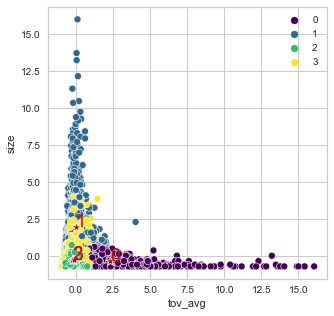

In [306]:
X = prefix_clustering[["tov_avg", "size", "urban_coastal"]].copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

# adding the labels obtained from clustering
clusters = cluster.AgglomerativeClustering(n_clusters=4).fit(X_std)
labels = clusters.labels_
X_std["label"] = clusters.labels_

centroids = pd.DataFrame(data=X_std.groupby("label").mean(), 
                         columns= X.columns
                        ) 

fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=X_std, x="tov_avg", y="size", hue="label", palette="viridis", ax=ax)
sns.scatterplot(data=centroids, x="tov_avg", y="size", marker="*", s=100, color="r", ax=ax)

for i in range(centroids.shape[0]):
    ax.text(centroids.to_numpy()[i, 0], centroids.to_numpy()[i, 1], str(i), fontsize=18, color="r")

In [320]:
real_centroids = pd.DataFrame(scaler.inverse_transform(centroids), columns=centroids.columns)
#real_centroids["urban_coastal"] = real_centroids["urban_coastal"].apply(lambda x: "urban/coastal" if x>0.5 else "rural/inland")
real_centroids["count"] = sorted(Counter(clusters.labels_).items())
real_centroids["count"] = real_centroids["count"].apply(lambda x: x[1])
real_centroids

,tov_avg,size,urban_coastal,count
0,488.553183,3.793755,6.006574e-01,1217
1,159.566609,23.419238,9.927405e-01,1653
2,126.997737,4.532136,1.000000e+00,8573
3,142.492170,4.735198,1.298961e-14,3361


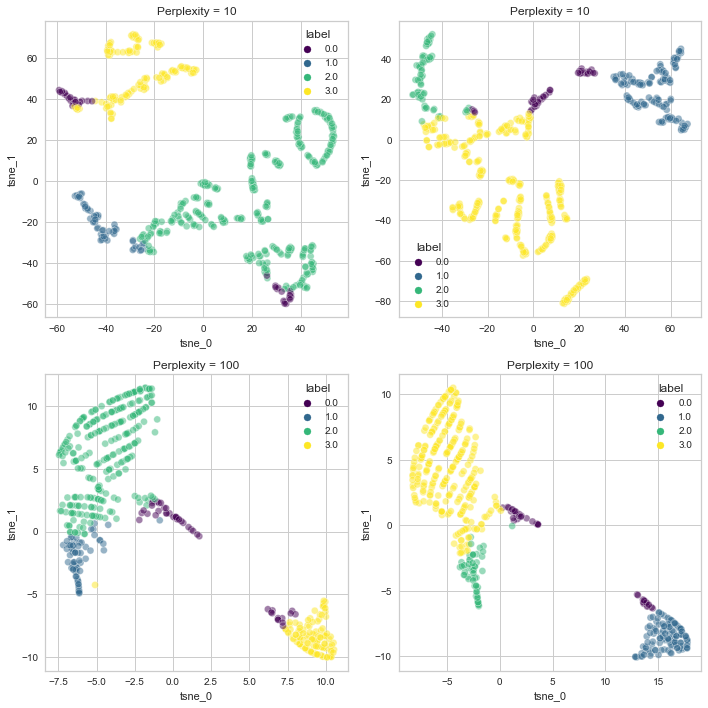

In [325]:
X = prefix_clustering[["tov_avg", "size", "urban_coastal"]].copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

fig = plt.figure(figsize=(10, 10))

for i, perp in zip(range(4), [10, 10, 100, 100]):
    X_std = X_std.sample(frac=1).reset_index(drop=True)
    clusters = cluster.AgglomerativeClustering(n_clusters=4).fit(X_std)
    
    # adding the labels obtained from clustering
    X_std["label"] = clusters.labels_
    
    # Visualization
    XX = X_std.sample(1000).copy()
    X = XX.drop(columns="label")
    tsne = manifold.TSNE(n_components=2, perplexity=perp, n_iter=3000)
    X_tsne = tsne.fit_transform(X)
    
    X_tsne = pd.DataFrame(data=np.concatenate((X_tsne, np.array(XX.label, ndmin=2).T), axis=1),
                          columns=["tsne_0", "tsne_1", "label"])
    
    
    ax = fig.add_subplot(2, 2, i+1)
    sns.scatterplot(data=X_tsne, x="tsne_0", y="tsne_1", hue="label", palette="viridis", alpha=0.5, ax=ax)
    ax.set_title(f"Perplexity = {perp}")
    
plt.tight_layout()
plt.show()

A bit more balanced clusters than KMeans

In [326]:
X = prefix_clustering[["tov_avg", "size", "urban_coastal"]].copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

# adding the labels obtained from clustering
clusters = cluster.KMeans(n_clusters=4).fit(X_std)
labels = clusters.labels_
prefix_clustering["zip_category"] = clusters.labels_
prefix_clustering.to_csv("./data/prefix_clustering.csv", index_label=False)

In [169]:
city_clustering = pd.read_csv("./data/city_clustering.csv")
city_clustering.head()

,customer_city,geolocation_lat,geolocation_lng,tov_avg,size
0,abadia dos dourados,-18.474476,-47.407837,137.833333,3.0
1,abadiania,-16.193742,-48.709521,1025.520000,1.0
2,abaete,-19.158206,-45.446300,162.234167,12.0
3,abaetetuba,-1.723024,-48.881065,424.751818,11.0
4,abaiara,-7.358247,-39.045817,166.075000,2.0


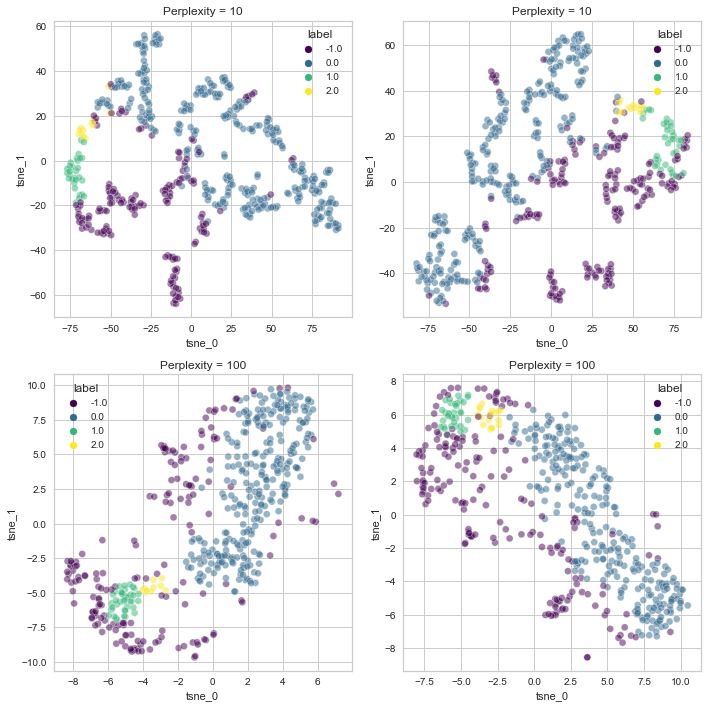

In [170]:
X = city_clustering.drop(columns=["customer_city"]).copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

fig = plt.figure(figsize=(10, 10))

for i, perp in zip(range(4), [10, 10, 100, 100]):
    X_std = X_std.sample(frac=1).reset_index(drop=True)
    dbscan = cluster.DBSCAN(eps=0.4, min_samples=75).fit(X_std)
    
    # adding the labels obtained from clustering
    X_std["label"] = dbscan.labels_
    
    # Visualization
    XX = X_std.sample(500).copy()
    X = XX.drop(columns="label")
    tsne = manifold.TSNE(n_components=2, perplexity=perp, n_iter=3000)
    X_tsne = tsne.fit_transform(X)
    
    X_tsne = pd.DataFrame(data=np.concatenate((X_tsne, np.array(XX.label, ndmin=2).T), axis=1),
                          columns=["tsne_0", "tsne_1", "label"])
    
    
    ax = fig.add_subplot(2, 2, i+1)
    sns.scatterplot(data=X_tsne, x="tsne_0", y="tsne_1", hue="label", palette="viridis", alpha=0.5, ax=ax)
    ax.set_title(f"Perplexity = {perp}")
    
plt.tight_layout()
plt.show()

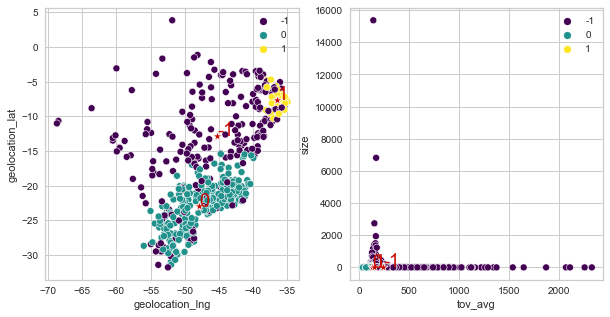

In [213]:
X = city_clustering.drop(columns=["customer_city"]).copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

dbscan = cluster.DBSCAN(eps=0.4, min_samples=125).fit(X_std)
    
# adding the labels obtained from clustering
X["label"] = dbscan.labels_

centroids = pd.DataFrame(data=X.groupby("label").mean(), 
                         columns= X.columns
                        ) 

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(data=X.sample(500), x="geolocation_lng", y="geolocation_lat", hue="label", palette="viridis", ax=ax)
sns.scatterplot(data=centroids, x="geolocation_lng", y="geolocation_lat", marker="*", s=100, color="r", ax=ax)

for i in range(centroids.shape[0]):
    ax.text(centroids.to_numpy()[i, 1], centroids.to_numpy()[i, 0], str(i-1), fontsize=18, color="r")

ax = fig.add_subplot(1, 2, 2)
sns.scatterplot(data=X, x="tov_avg", y="size", hue="label", palette="viridis", ax=ax)
sns.scatterplot(data=centroids, x="tov_avg", y="size", marker="*", s=100, color="r", ax=ax)

for i in range(centroids.shape[0]):
    ax.text(centroids.to_numpy()[i, 2], centroids.to_numpy()[i, 3], str(i-1), fontsize=18, color="r")
plt.show()

Preparing the datasets

In [180]:
X = city_clustering.drop(columns=["customer_city"]).copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

Finding out the optimal number of clusters
1. Silhouette score

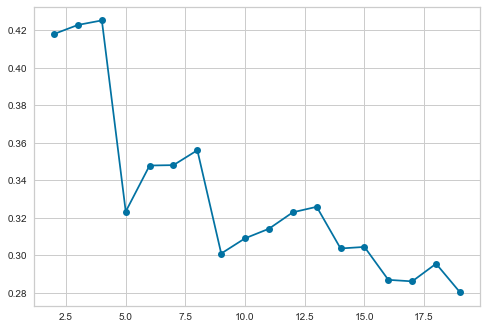

In [181]:
silhouettes = []

for num_clusters in range(2, 20):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(X_std)
    silh = metrics.silhouette_score(X_std, cls.labels_)
    silhouettes.append(silh)

plt.plot(range(2, 20), silhouettes, marker='o')

2. Elbow method

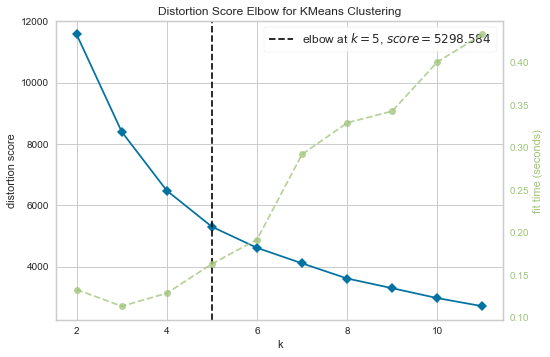

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [182]:
# Instantiate the clustering model and visualizer
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_std)    # Fit the data to the visualizer
visualizer.poof() 

Assessing the shape of clusters

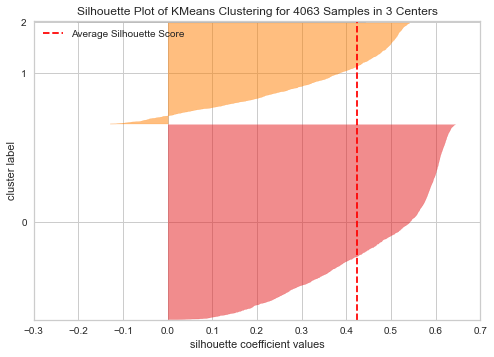

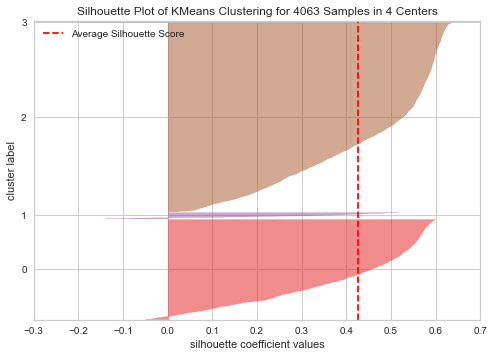

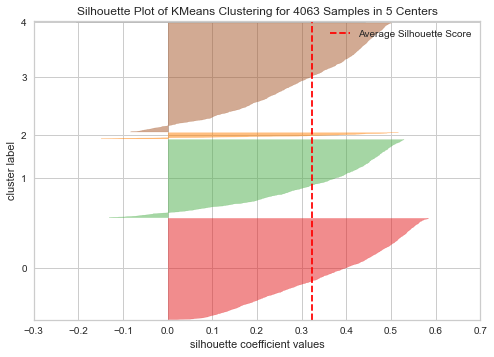

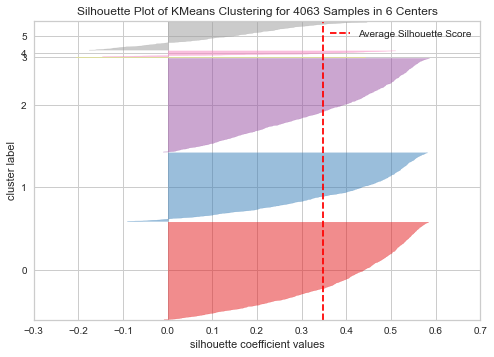

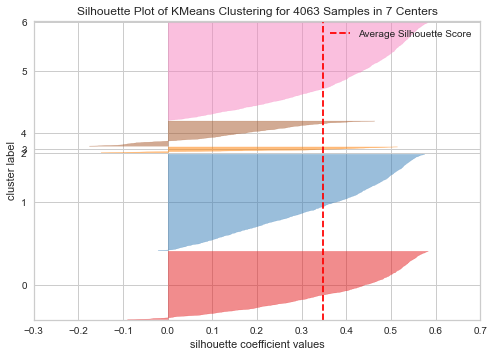

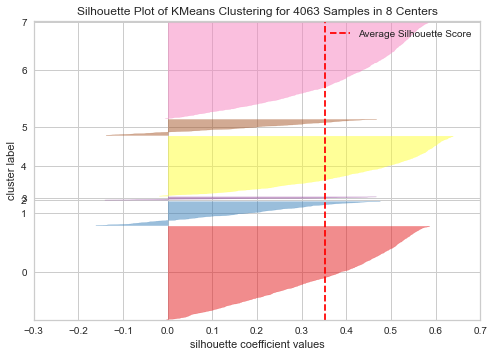

In [183]:
for n_clust in range(3, 9):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(X_std)    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

Assessing the stabilility of the clusters

In [193]:
clusters.cluster_centers_

array([[-5.78891830e-01, -5.15672673e-01, -1.88931445e-01,
        -2.91988238e-04,  3.00000000e+00],
       [ 1.06792941e+00,  9.64791900e-01,  5.03776618e-02,
        -5.23430616e-02,  1.00000000e+00],
       [-6.87814976e-01,  2.21722955e-01, -1.40526020e-01,
         3.98419678e+01,  2.00000000e+00],
       [ 4.23774795e-01,  1.42281111e-01,  4.90690949e+00,
        -8.02442485e-02,  0.00000000e+00]])

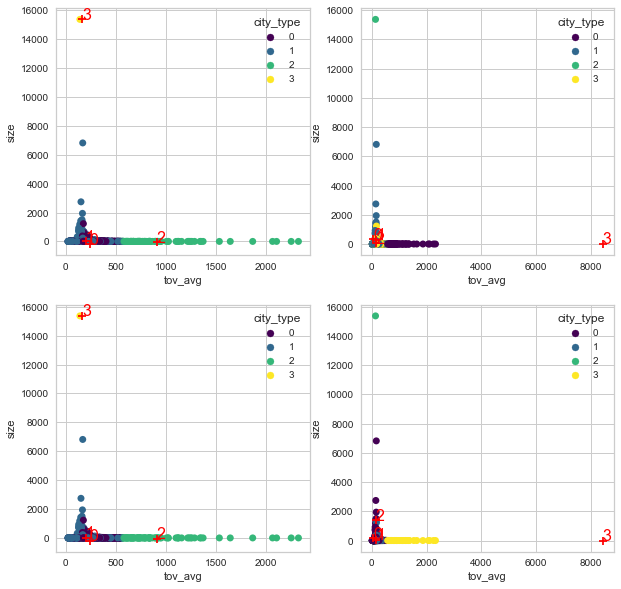

In [196]:
X = city_clustering.drop(columns=["customer_city"]).copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

fig = plt.figure(figsize=(10, 10))
for i in range(4):
    clusters = cluster.KMeans(n_clusters=4).fit(X_std)
    labels = clusters.labels_
    X["city_type"] = labels
    centers = scaler.inverse_transform(clusters.cluster_centers_.T)

    ax = fig.add_subplot(2, 2, i+1)
    sns.scatterplot(data=X,
                    x="tov_avg",
                    y="size",
                    hue="city_type",
                    palette="viridis",
                    alpha=1,
                    linewidth=0,
                    ax=ax
                   )
    
    ax.scatter(centers[:, 2], centers[:, 3], s=50, c='red', marker="+")
    for i in range(len(np.unique(labels))):
        ax.text(centers[i, 2], centers[i, 3], i, fontsize=16, color='red')

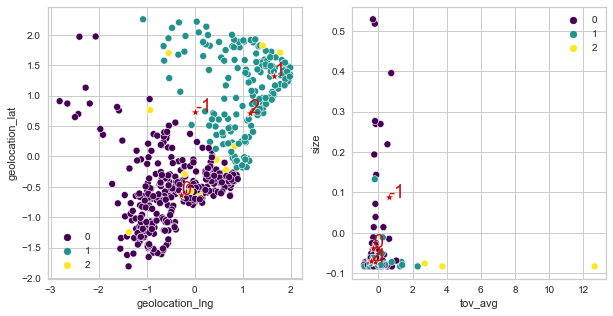

In [201]:
X = city_clustering.drop(columns=["customer_city"]).copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

# adding the labels obtained from clustering
clusters = cluster.KMeans(n_clusters=4).fit(X_std)
labels = clusters.labels_
X_std["label"] = clusters.labels_

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(data=X_std.sample(500), x="geolocation_lng", y="geolocation_lat", hue="label", palette="viridis", ax=ax)
sns.scatterplot(data=centroids, x="geolocation_lng", y="geolocation_lat", marker="*", s=100, color="r", ax=ax)

for i in range(centroids.shape[0]):
    ax.text(centroids.to_numpy()[i, 1], centroids.to_numpy()[i, 0], str(i-1), fontsize=18, color="r")

ax = fig.add_subplot(1, 2, 2)
sns.scatterplot(data=X_std.sample(100), x="tov_avg", y="size", hue="label", palette="viridis", ax=ax)
sns.scatterplot(data=centroids, x="tov_avg", y="size", marker="*", s=100, color="r", ax=ax)

for i in range(centroids.shape[0]):
    ax.text(centroids.to_numpy()[i, 2], centroids.to_numpy()[i, 3], str(i-1), fontsize=18, color="r")
plt.show()

Trying another clustering algorithm (agglomerative clustering)

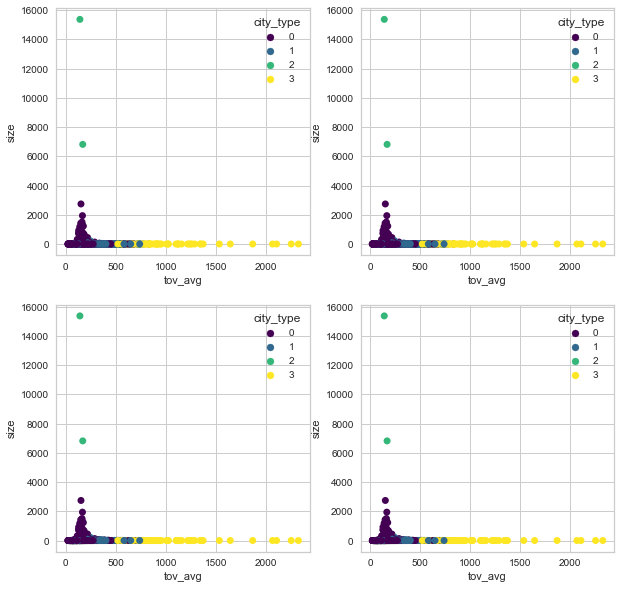

In [197]:
X = city_clustering.drop(columns=["customer_city"]).copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

fig = plt.figure(figsize=(10, 10))
for i in range(4):
    clusters = cluster.AgglomerativeClustering(n_clusters=4).fit(X_std)
    labels = clusters.labels_
    X["city_type"] = labels
    #X_std = pd.DataFrame(cluster_cities_std, columns=["tov_avg", "size"])
    X_std["city_type"] = labels
    #centers = scaler.inverse_transform(clusters.cluster_centers_)


    ax = fig.add_subplot(2, 2, i+1)
    sns.scatterplot(data=X,
                    x="tov_avg",
                    y="size",
                    hue="city_type",
                    palette="viridis",
                    alpha=1,
                    linewidth=0,
                    ax=ax
                   )


    #ax.scatter(centers[:, 0], centers[:, 1], s=50, c='red', marker="+")
    #for i in range(len(np.unique(labels))):
    #    ax.text(centers[i, 0], centers[i, 1], i, fontsize=16, color='red')

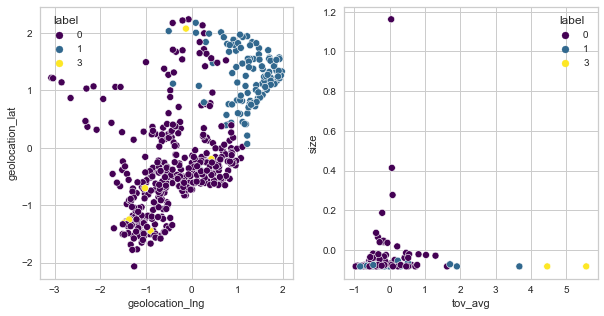

In [202]:
X = city_clustering.drop(columns=["customer_city"]).copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

# adding the labels obtained from clustering
clusters = cluster.AgglomerativeClustering(n_clusters=4).fit(X_std)
labels = clusters.labels_
X_std["label"] = clusters.labels_

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(data=X_std.sample(500), x="geolocation_lng", y="geolocation_lat", hue="label", palette="viridis", ax=ax)
#sns.scatterplot(data=centroids, x="geolocation_lng", y="geolocation_lat", marker="*", s=100, color="r", ax=ax)

#for i in range(centroids.shape[0]):
#    ax.text(centroids.to_numpy()[i, 1], centroids.to_numpy()[i, 0], str(i-1), fontsize=18, color="r")

ax = fig.add_subplot(1, 2, 2)
sns.scatterplot(data=X_std.sample(100), x="tov_avg", y="size", hue="label", palette="viridis", ax=ax)
#sns.scatterplot(data=centroids, x="tov_avg", y="size", marker="*", s=100, color="r", ax=ax)

#for i in range(centroids.shape[0]):
#    ax.text(centroids.to_numpy()[i, 2], centroids.to_numpy()[i, 3], str(i-1), fontsize=18, color="r")
plt.show()

AgglomerativeClustering gives the exact same result.

Clustering the neighborhoods with DBSCAN has an advantage: the closer neighborhoods are with each other, the higher the chance for them to be clustered in the same group. This means that with DBSCAN, we can almost "naturally" get the dense vs sparse areas. This is not the case if one clusters at the city level: a city like Sao Paulo might be too "far" from the next city and will be categorized as "noise", yet it is one if not the most densely populated region in Brazil, which means that the clustering will give wrong results here. Therefore we choose to continue with the DBSCAN clustering over the neighborhoods referenced by their zip codes.

In [208]:
rfm_customers = pd.read_csv("./data/rfm_customers.csv")
rfm_customers.head()

,customer_unique_id,purchase_recency,frequency,total_order_value,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,142.0,fadbb3709178fc513abc1b2670aa1ad2,7787,cajamar,SP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.0,4cb282e167ae9234755102258dd52ee8,6053,osasco,SP
2,0000f46a3911fa3c0805444483337064,585,1,86.0,9b3932a6253894a02c1df9d19004239f,88115,sao jose,SC
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,44.0,914991f0c02ef0843c0e7010c819d642,66812,belem,PA
4,0004aac84e0df4da2b147fca70cf8255,336,1,197.0,47227568b10f5f58a524a75507e6992c,18040,sorocaba,SP


In [124]:
# We can reuse the rfm_customers dataset
cluster_cities = (rfm_customers
     .groupby("customer_city", dropna=False)["total_order_value"]
     .agg([np.mean, np.size])
     .rename(columns={"mean":"tov_avg", 
                     })
    )

cluster_cities.head()

,tov_avg,size
customer_city,,
abadia dos dourados,138.000000,3.0
abadiania,1026.000000,1.0
abaete,162.166667,12.0
abaetetuba,424.818182,11.0
abaiara,166.000000,2.0


Getting representatives for each cluster

In [ ]:
# distance to centroids
X_dist = clusters.transform(X_std)

for ct in np.unique(labels):
    label_indices = np.where(labels==ct)[0]
    min_label_idx = label_indices[np.argmin(X_dist[labels==ct, ct])]
    print("Best representative of type {}: {}".format(ct, X.reset_index().iloc[min_label_idx]["customer_city"]))